In [185]:
from scipy.io import loadmat
import mne
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [148]:
# fpath of subject 1 session 1 data:
subject = 1
session = 1
fpath = f"data/sub%02d_ses%d.mat" % (subject, session)

## Structure of mat files

```
run{idx}.eeg        raw EEG data (n_samples x n_channels) 
run{idx}.header     metadata

header.Subject      subject number
header.Session      Session number
header.SampleRate   Recording sampling rate
header.Label        Electrode labels
header.EVENT        Recording events

header.EVENT.POS    Position of event
header.EVENT.TYP    Type of event
```

In [155]:
# Load the data
raw = loadmat(fpath, simplify_cells=1)
raw = raw['run']

# load first trial
trial = raw[0]

### extract metadata

In [151]:
# extract metadata
sf = trial['header']['SampleRate']
ch_names = list(trial['header']['Label'][:-1])
ch_types = ['eeg'] * len(ch_names)

info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sf)
info.set_montage("standard_1020")
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 512.0 Hz
>


Creating RawArray with float64 data, n_channels=64, n_times=91648
    Range : 0 ... 91647 =      0.000 ...   178.998 secs
Ready.
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


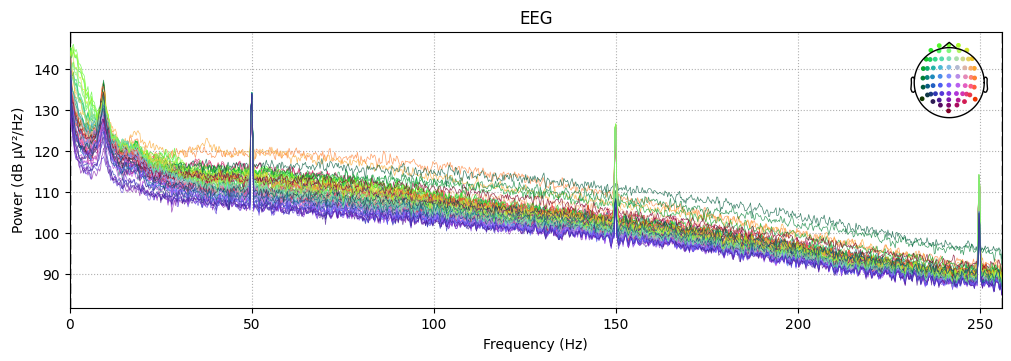

In [156]:
rawdata = trial['eeg'].transpose()
rawmne = mne.io.RawArray(rawdata, info)
rawmne.compute_psd().plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 16897 samples (33.002 s)

Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


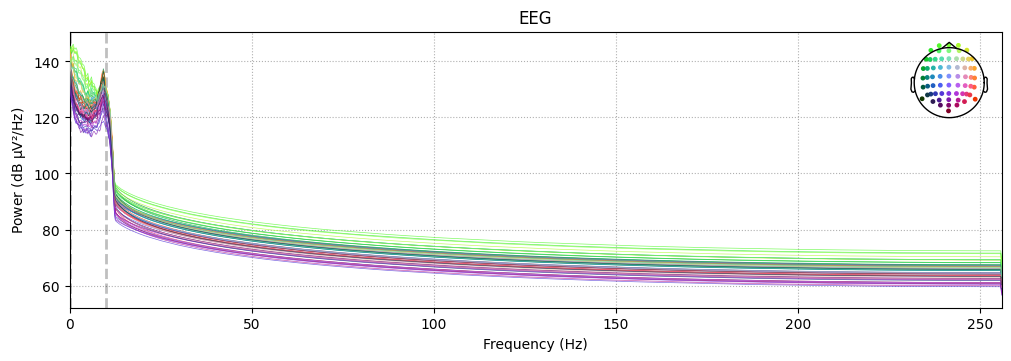

In [157]:
filtmne = rawmne.copy().filter(l_freq=0.1, h_freq=10)
filtmne.compute_psd().plot()

In [210]:
events_pos = np.array(trial['header']['EVENT']['POS'], dtype=int)
events_type = np.array(trial['header']['EVENT']['TYP'], dtype=int)

un, co = np.unique(events_type, return_counts=True)
for u,c in zip(un,co):
    print(f"event {u} with count {c}")

nevents = len(events_pos)
eventsarr = np.zeros([nevents, 3], dtype=int)
eventsarr[:,0]= events_pos
eventsarr[:,2] = events_type

event 1 with count 7
event 2 with count 10
event 4 with count 3
event 5 with count 19
event 6 with count 1
event 8 with count 9
event 9 with count 4
event 10 with count 16


events 5,10 = correct movement <br>
events 6,9 = erroneous movement

In [225]:
# epoch = mne.Epochs(raw=filtmne, events = eventsarr, event_id = dict(correct_1=5, correct_2=10, erroneous_1=9, erroneous_2=9), tmin=-0.2, tmax=0.85)
epoch = mne.Epochs(raw=filtmne, events = eventsarr, tmin=-0.1, tmax=0.85)
epoch

Not setting metadata
69 matching events found
Setting baseline interval to [-0.099609375, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


<Epochs | 69 events (good & bad), -0.1 – 0.85 s (baseline -0.1 – 0 s), ~75 KiB, data not loaded,
 '1': 7
 '2': 10
 '4': 3
 '5': 19
 '6': 1
 '8': 9
 '9': 4
 '10': 16>

In [226]:
correct = epoch[['5','10']].average()
erroneous = epoch[['6','9']].average()

No projector specified for this dataset. Please consider the method self.add_proj.


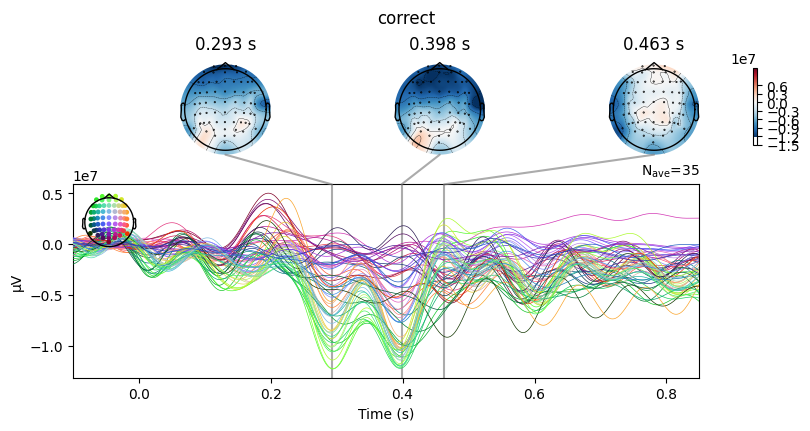

No projector specified for this dataset. Please consider the method self.add_proj.


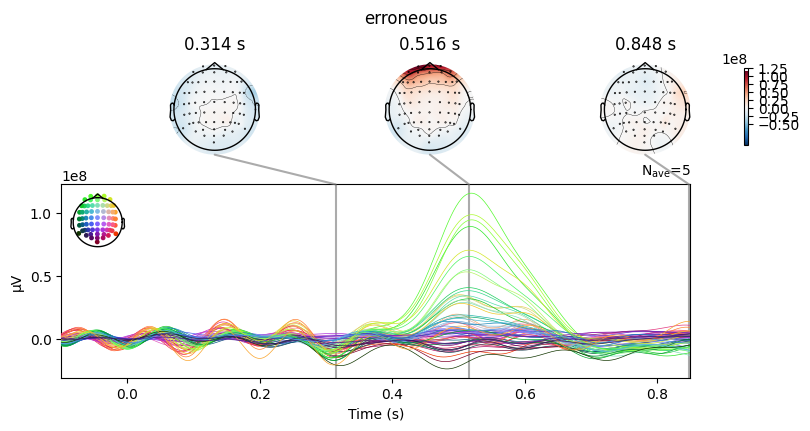

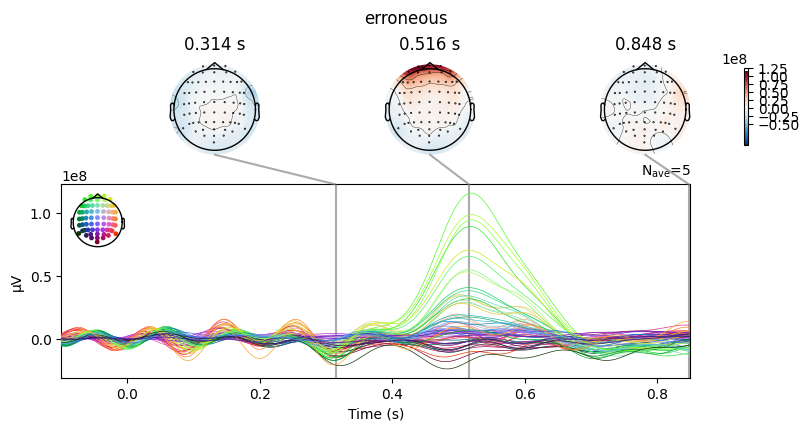

In [227]:
correct.plot_joint(title='correct')
erroneous.plot_joint(title='erroneous')